# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro



### Importar Bibliotecas e Bases de Dados

In [1]:

import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
import gc


### Consolidar Base de Dados

In [2]:
#Importamos uma base de dados mas temos que percorer todos as bases de dados

#Colocar meses e anos no DF
meses = {'jan': 1, 'fev':2, 'mar':3, 'abr': 4, 'mai':5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

  #Usamos o pathlib
caminhos_bases =  pathlib.Path('dataset')

#Lista de DFs
lista_DF = []                   #Criar um DF vazio, assim sempre que aparecer mais um adicionar
#Percorrer todos
for arquivo in caminhos_bases.iterdir():  
    nome_mes = arquivo.name[:3]                       #o nome do mes são os 3 primeiras letras
    mes = meses[nome_mes]
    
    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv',''))

    df = pd.read_csv(caminhos_bases / arquivo.name) 
    df['ano'] = ano
    df['mes'] = mes
    lista_DF.append(df)

#Concatenar todos os dataframes

base_airbnb = pd.concat(lista_DF, ignore_index=True)



C:\Users\gabri\AppData\Local\Temp\ipykernel_13352\3268678617.py:19: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminhos_bases / arquivo.name)
C:\Users\gabri\AppData\Local\Temp\ipykernel_13352\3268678617.py:19: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminhos_bases / arquivo.name)
C:\Users\gabri\AppData\Local\Temp\ipykernel_13352\3268678617.py:19: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminhos_bases / arquivo.name)
C:\Users\gabri\AppData\Local\Temp\ipykernel_13352\3268678617.py:19: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminhos_bases / arquivo.name)
C:\Users\gabri\AppData\Local\Temp\ipykernel_13352\3268678617.py:19: DtypeWarning: Columns (61,62,94) have mix

### Já vamos identificar quais colunas podemos excluir

- Como temos muitas colunas, nosso modelo fica lento.
- E temos colunas Desnecessárias

#### Iremos lidas apenas com as seguinte colunas

In [3]:
#Lista as colunas
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

#Lidar apenas com as colunas abaixo
base_airbnb = base_airbnb.loc[:,colunas]

display(base_airbnb)

host_response_time host_response_rate host_is_superhost  \
0                      NaN                NaN                 f   
1           within an hour               100%                 t   
2           within an hour               100%                 f   
3           within an hour               100%                 f   
4           within an hour               100%                 t   
...                    ...                ...               ...   
902205      within an hour                93%                 f   
902206                 NaN                NaN                 f   
902207  within a few hours                74%                 f   
902208                 NaN                NaN                 f   
902209  a few days or more                38%                 f   

        host_listings_count   latitude  longitude property_type  \
0                       1.0 -22.946854 -43.182737     Apartment   
1                       2.0 -22.965919 -43.178962   Condominium   
2                       1.0 -22.985698 -43.201935     Apartment   
3                       3.0 -22.977117 -43.190454     Apartment   
4                       1.0 -22.983024 -43.214270     Apartment   
...                     ...        ...        ...           ...   
902205                  0.0 -23.003180 -43.342840     Apartment   
902206                  0.0 -22.966640 -43.393450     Apartment   
902207                 32.0 -22.962080 -43.175520     Apartment   
902208                  0.0 -23.003400 -43.341820     Apartment   
902209                  5.0 -23.010560 -43.363350     Apartment   

              room_type  accommodates  bathrooms  ...  \
0       Entire home/apt             4        1.0  ...   
1       Entire home/apt             5        1.0  ...   
2       Entire home/apt             2        1.0  ...   
3       Entire home/apt             3        1.0  ...   
4       Entire home/apt             3        1.0  ...   
...                 ...           ...        ...  ...   
902205  Entire home/apt             4        1.0  ...   
902206  Entire home/apt             4        2.0  ...   
902207  Entire home/apt             5        1.0  ...   
902208  Entire home/apt             4        1.0  ...   
902209     Private room             2        0.0  ...   

        review_scores_cleanliness  review_scores_checkin  \
0                             9.0                    9.0   
1                             9.0                   10.0   
2                            10.0                   10.0   
3                            10.0                   10.0   
4                            10.0                   10.0   
...                           ...                    ...   
902205                        NaN                    NaN   
902206                        NaN                    NaN   
902207                        NaN                    NaN   
902208                        NaN                    NaN   
902209                        NaN                    NaN   

       review_scores_communication review_scores_location review_scores_value  \
0                              9.0                    9.0                 9.0   
1                             10.0                    9.0                 9.0   
2                             10.0                   10.0                 9.0   
3                             10.0                   10.0                 9.0   
4                             10.0                   10.0                 9.0   
...                            ...                    ...                 ...   
902205                         NaN                    NaN                 NaN   
902206                         NaN                    NaN                 NaN   
902207                         NaN                    NaN                 NaN   
902208                         NaN                    NaN                 NaN   
902209                         NaN                    NaN                 NaN   

       instant_book

### Tratar Valores Faltando

Verificando os dados percebemos que há uma grande quantidade de valores vazios.Assim pela minha métrica, colunas com valores vazios acima de 300.000 seriam removidos do DF

E linhas com valores ainda vazios, iremos excluir

In [4]:

#quando vc percorre um DF, vc percorre as colunas

for coluna in base_airbnb:
  if base_airbnb[coluna].isnull().sum() > 300000:
    base_airbnb = base_airbnb.drop(coluna, axis=1)
#Verificar valores faltantes
print(base_airbnb.isnull().sum())
#mostra total de linhas e colunas
print(base_airbnb.shape)


host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64
(902210, 23)


In [5]:
#Retirando as linhas faltantes com NAN
base_airbnb = base_airbnb.dropna()

print(base_airbnb.shape)

#verificando
print(base_airbnb.isnull().sum())

(897709, 23)
host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

In [6]:
print(base_airbnb.dtypes)
print('-' * 80)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
--------------------------------------------------------------------------------
host_is_superhost                                                           f

- price, extra_people, estão sendo reconhecidos como obj invés de float, então iremos mudar o tipo de variável da coluna

In [7]:
#Remover "$" e "," da coluna price 
base_airbnb['price'] = base_airbnb['price'].str.replace('$','')
base_airbnb['price'] = base_airbnb['price'].str.replace(',','')
#mudar o tipo de dado da coluna
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)
#extra people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$','')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',','')
#mudar o tipo de dado da coluna
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)    
#verificar
print(base_airbnb.dtypes)            

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


### Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para:

    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.

    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1

    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir

- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

  

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

  

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

<Axes: >

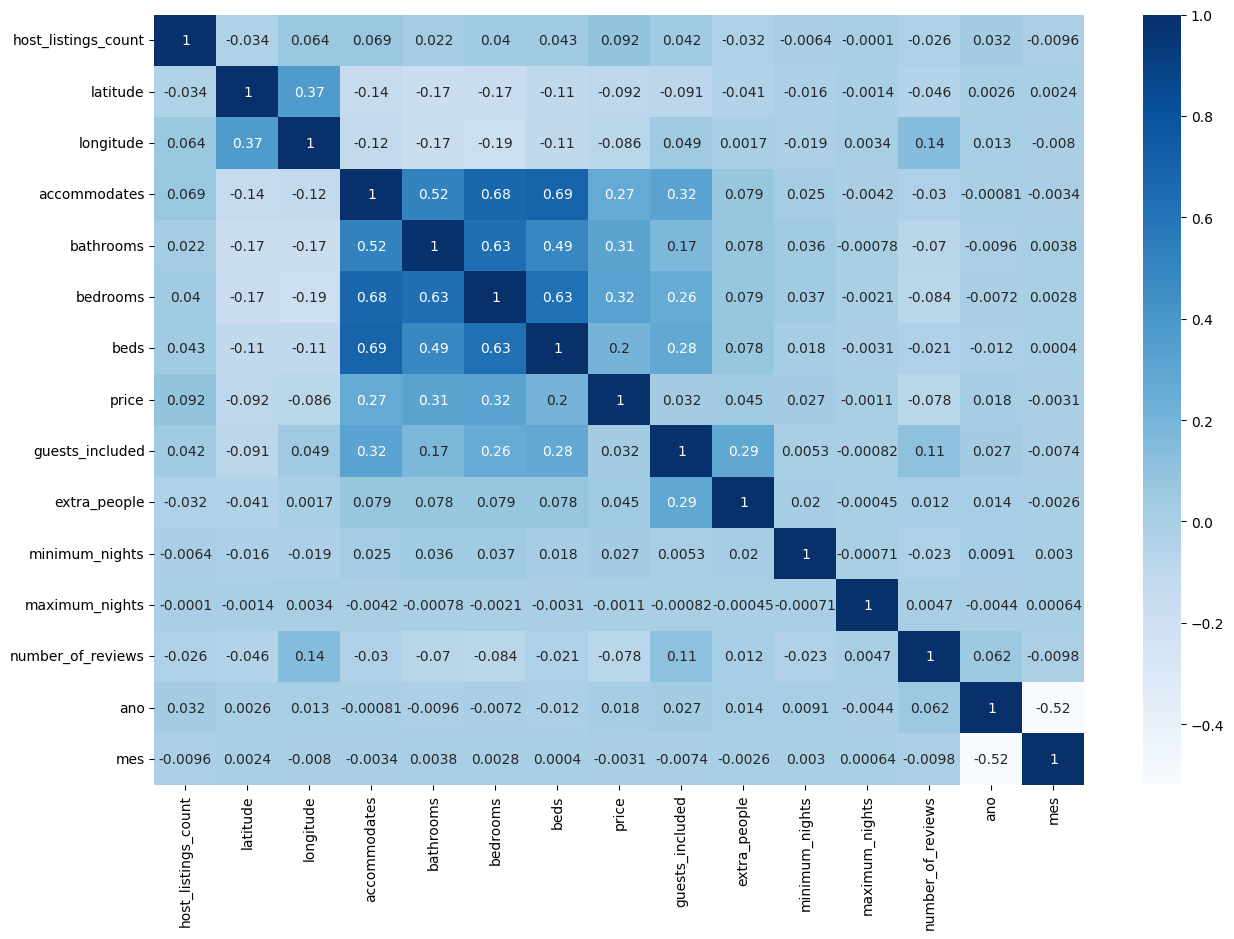

In [8]:
#Gráfico
plt.figure(figsize=(15,10))
#mapa de calor
sns.heatmap(base_airbnb.corr(numeric_only=True),annot=True, cmap='Blues')   #COr do mapa

#Vendo a correlação entre as colunas
#print(base_airbnb.corr(numeric_only=True))

### Definição de limites para Outliers

Iremos definir funções para ajudar na análise de outlier das colunas

In [9]:
def limites(coluna):
  q1 = coluna.quantile(0.25)
  q3 = coluna.quantile(0.75)
  amplitude = q3 - q1
  return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

#Função para remover linhas
def excluir_outliers(df, nome_coluna):
  qnt_linhas = df.shape[0]            #qtd de linhas do DF
  limite_inferior,limite_superior = limites(df[nome_coluna])
  df = df.loc[(df[nome_coluna] >= limite_inferior) & (df[nome_coluna] <= limite_superior), :]   #nosso DF, vamos filtrar apenas as linha onde os valores são maiores que o lim inferior e maior que limite superior
  linhas_excluidas = qnt_linhas - df.shape[0]
  return df, linhas_excluidas

#Verificando 
#print(base_airbnb['price'].describe())   #dá os detalhes da coluna, de quartil, média, min, max etc
#prova real
#print(381 + 1.5 * (601-151))

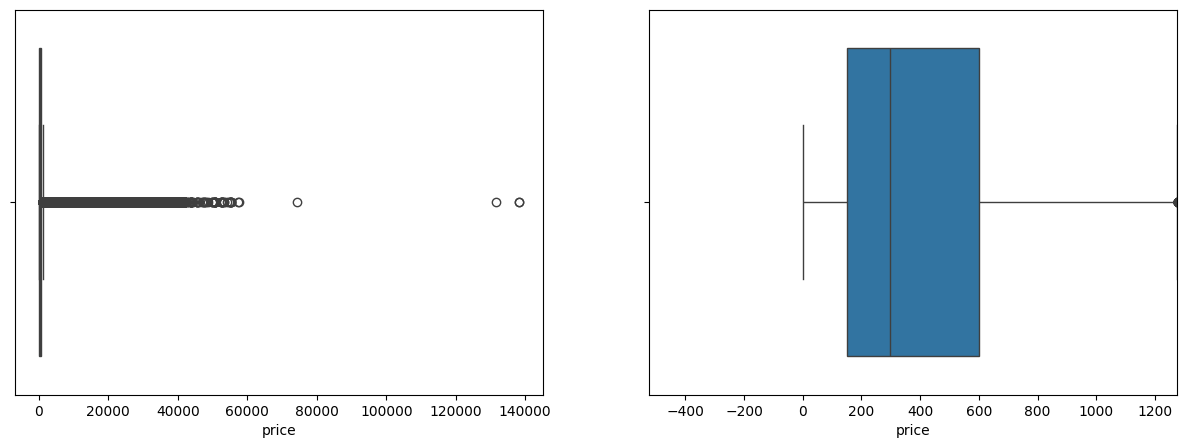

<Figure size 1500x500 with 0 Axes>

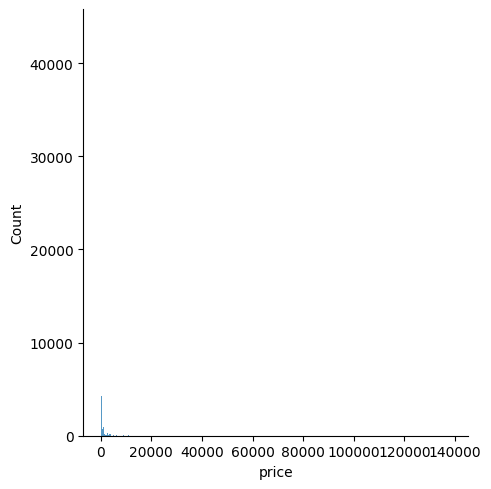

In [10]:
#Analisar Outliers de acordo com os gráficos
def diagrama_caixa(coluna):
 fig, (ax1, ax2) =  plt.subplots(1,2)
 fig.set_size_inches(15,5)
 sns.boxplot(x=coluna, ax=ax1)
 ax2.set_xlim(limites(coluna))
 sns.boxplot(x=coluna, ax=ax2)


def histograma(coluna):
  plt.figure(figsize=(15,5))
  sns.displot(coluna, element='bars')

def grafico_barras(coluna):
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))


diagrama_caixa(base_airbnb['price'])

histograma(base_airbnb['price'])

Estamos fazendo um modelo para imóveis comuns, acreditamos que os imóveis acima do limite padrão são apartamentos de luxo. Por isso, iremos excluir esses outliers

In [11]:
base_airbnb, qnt_linhas = excluir_outliers(base_airbnb, 'price')

print(f'Quantidade de linhas removidas: {qnt_linhas}')

Quantidade de linhas removidas: 87282


<Figure size 1500x500 with 0 Axes>

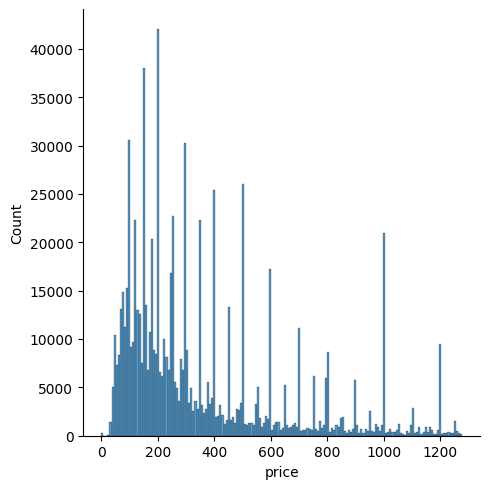

In [12]:
histograma(base_airbnb['price'])

### Analisando Coluna extra-people

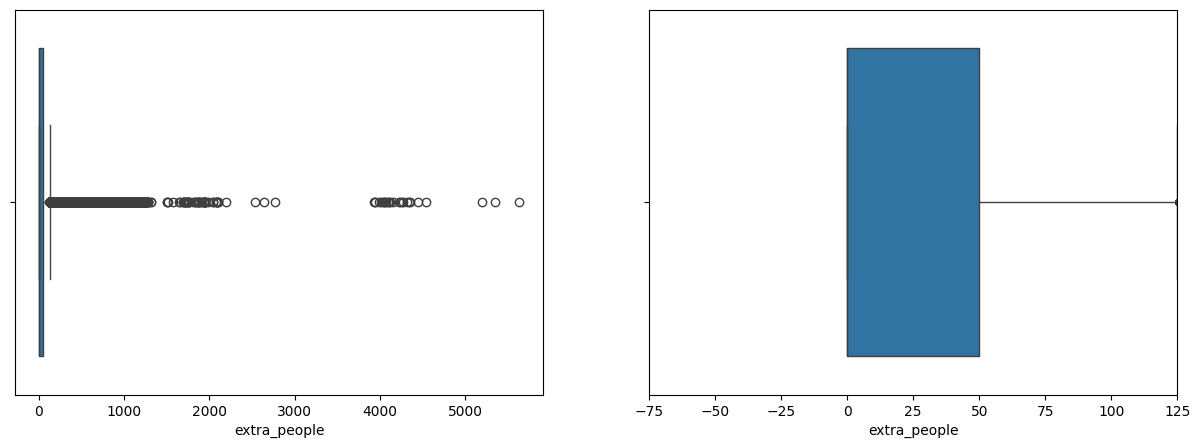

<Figure size 1500x500 with 0 Axes>

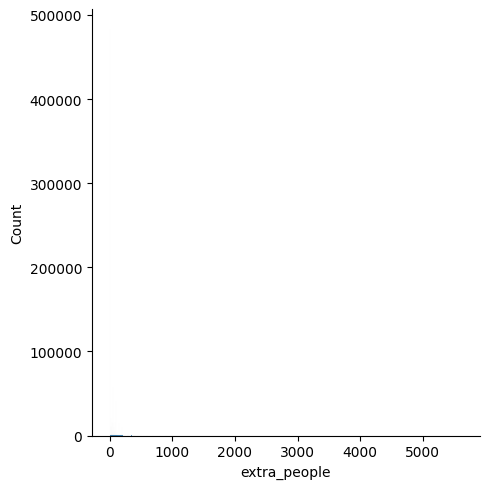

In [13]:
diagrama_caixa(base_airbnb['extra_people'])

histograma(base_airbnb['extra_people'])

In [14]:
#EXCLUIR OUTLIERS EXTRA_people
base_airbnb, qnt_linhas = excluir_outliers(base_airbnb, 'extra_people')

print(f'Quantidade de linhas removidas: {qnt_linhas}')

Quantidade de linhas removidas: 59194


### Analisando coluna host_listings_count 

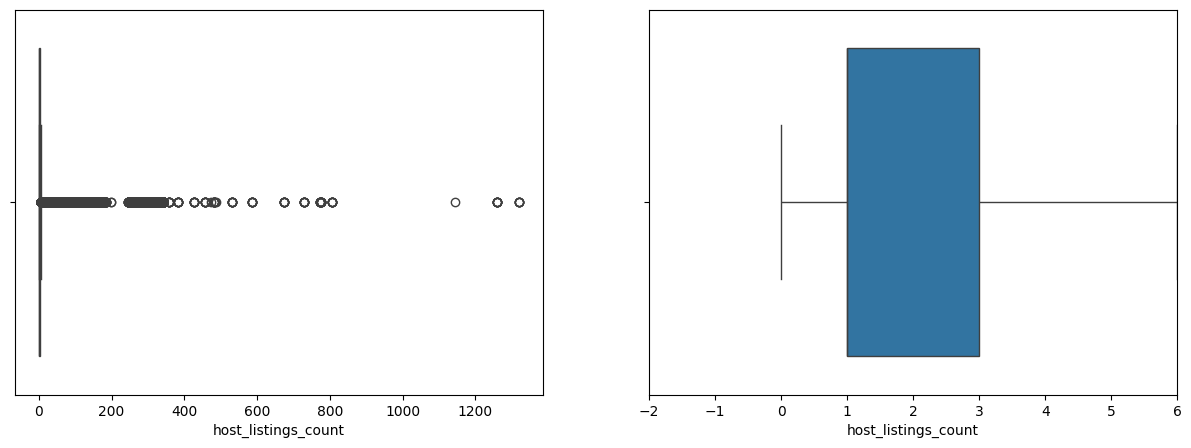

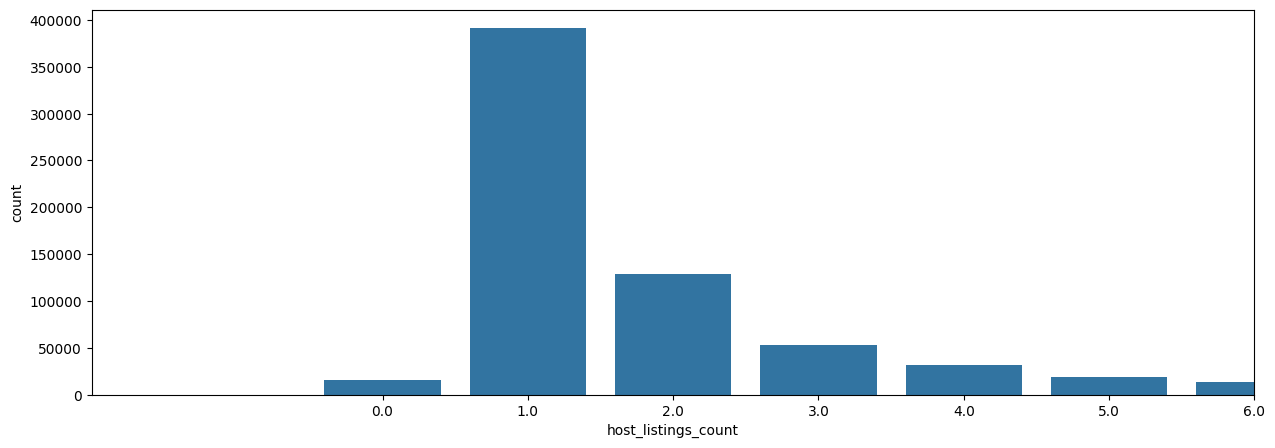

In [15]:
diagrama_caixa(base_airbnb['host_listings_count'])

grafico_barras(base_airbnb['host_listings_count'])

#### Podemos excluir os outlies para o objetivo do nosso projeto. Host com mais de seis imóveis, não é o objetivo do projeto.
- Imaginamos que seja imobliárias

In [16]:
base_airbnb, qnt_linhas = excluir_outliers(base_airbnb, 'host_listings_count')

print(f'Quantidade de linhas removidas: {qnt_linhas}')

Quantidade de linhas removidas: 97723


#### Coluna accommodate

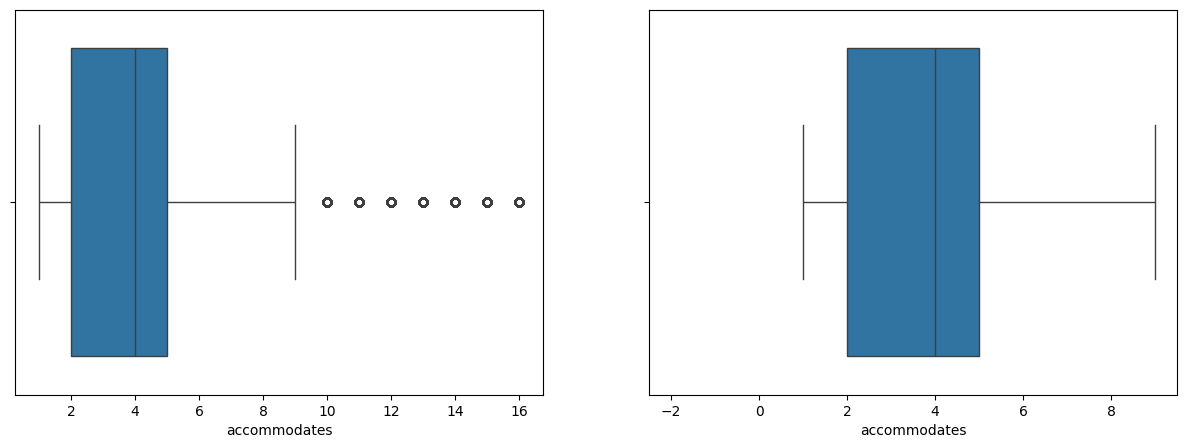

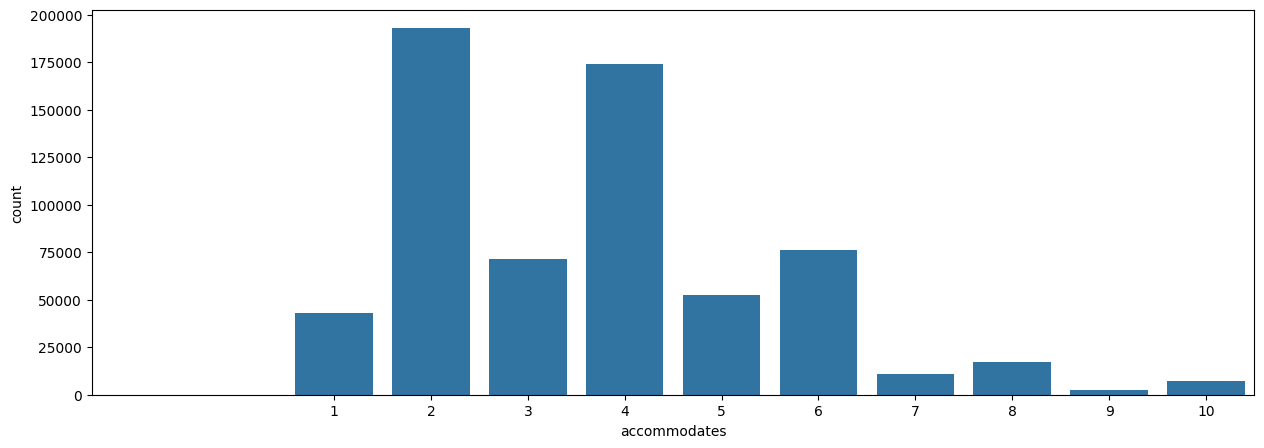

In [17]:
diagrama_caixa(base_airbnb['accommodates'])

grafico_barras(base_airbnb['accommodates'])

In [18]:
#Excluindo OUTLIERS accommodates
base_airbnb, qnt_linhas = excluir_outliers(base_airbnb, 'accommodates')

print(f'Quantidade de linhas removidas: {qnt_linhas}')

Quantidade de linhas removidas: 13146


### Analisando coluna bathrooms

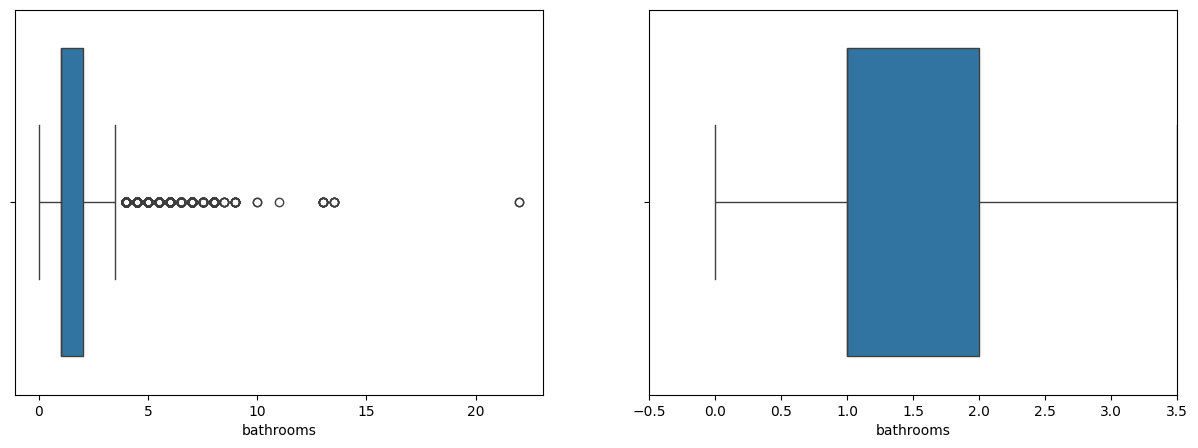

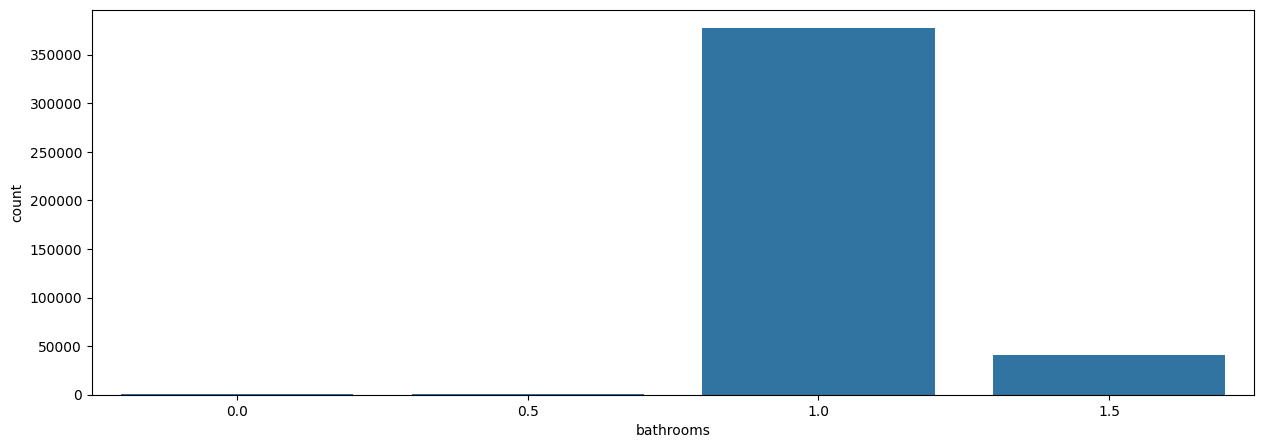

In [19]:
diagrama_caixa(base_airbnb['bathrooms'])

grafico_barras(base_airbnb['bathrooms'])



In [20]:
#Excluindo outliers bathrooms
base_airbnb, qnt_linhas = excluir_outliers(base_airbnb, 'bathrooms')

print(f'Quantidade de linhas removidas: {qnt_linhas}')

Quantidade de linhas removidas: 6894


#### Colunas Beds e Bedrooms

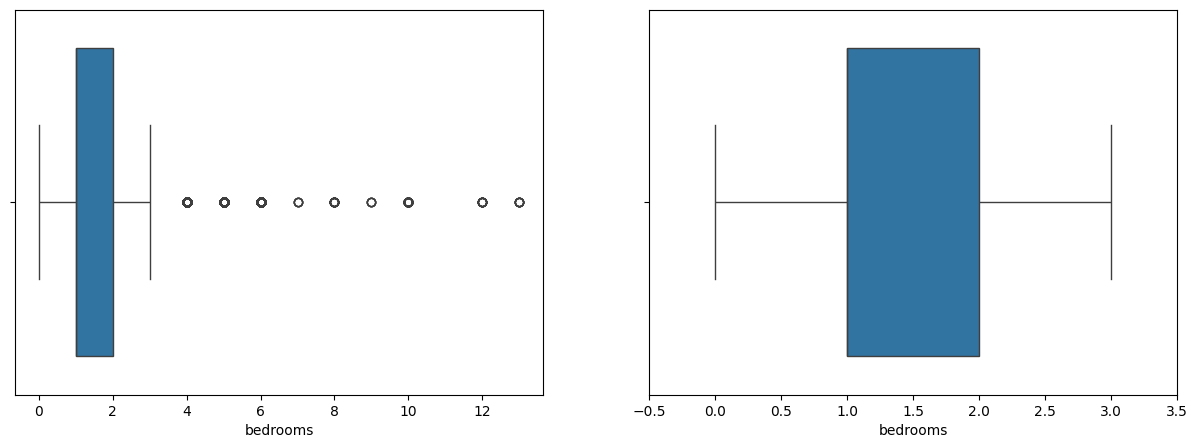

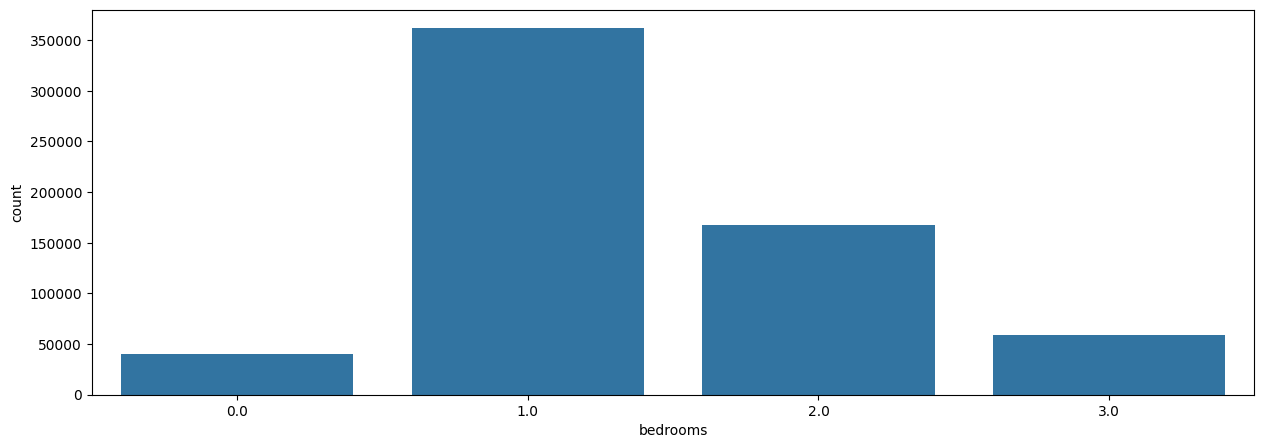

In [21]:
diagrama_caixa(base_airbnb['bedrooms'])

grafico_barras(base_airbnb['bedrooms'])

In [22]:
#REMOVENDO OUTLIERS DE QUARTOS

base_airbnb, qnt_linhas = excluir_outliers(base_airbnb, 'bedrooms')

print(f'Quantidade de linhas removidas: {qnt_linhas}')

Quantidade de linhas removidas: 5482


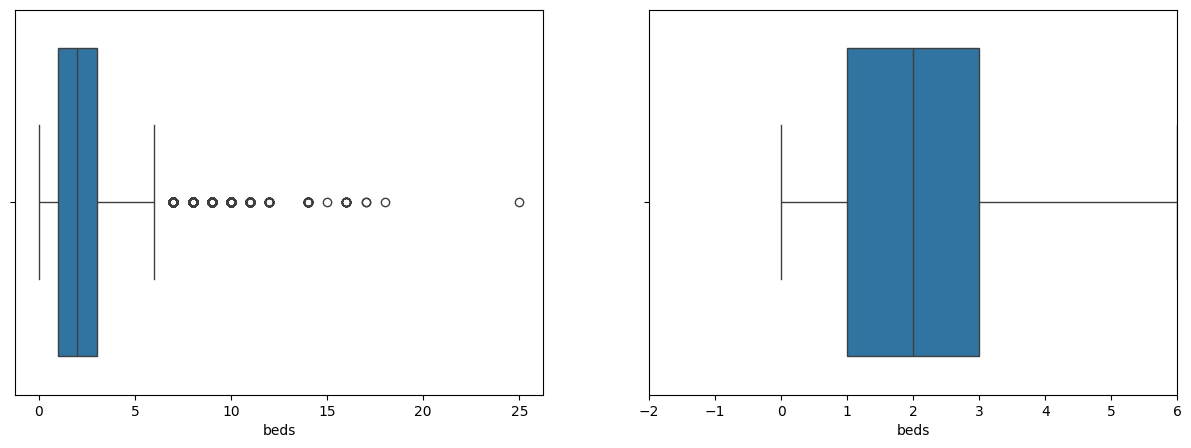

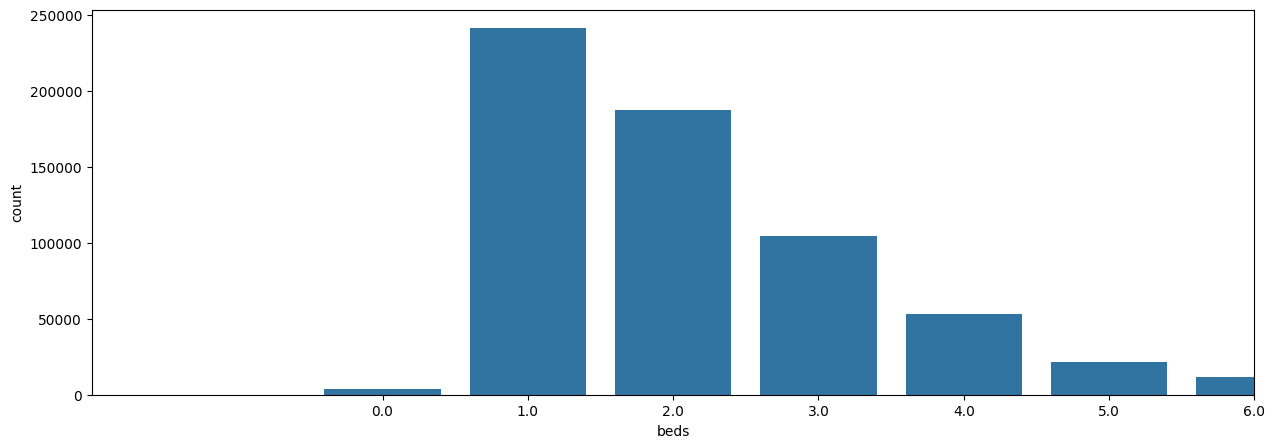

In [23]:
#Beds

diagrama_caixa(base_airbnb['beds'])

grafico_barras(base_airbnb['beds'])


In [24]:
#Removendo ouliers de Beds
base_airbnb, qnt_linhas = excluir_outliers(base_airbnb, 'beds')

print(f'Quantidade de linhas removidas: {qnt_linhas}')

Quantidade de linhas removidas: 5622


### Coluna guest_includes

C:\Users\gabri\AppData\Local\Temp\ipykernel_13352\1346621378.py:6: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\gabri\AppData\Local\Temp\ipykernel_13352\1346621378.py:17: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(limites(coluna))


<Axes: xlabel='guests_included', ylabel='count'>

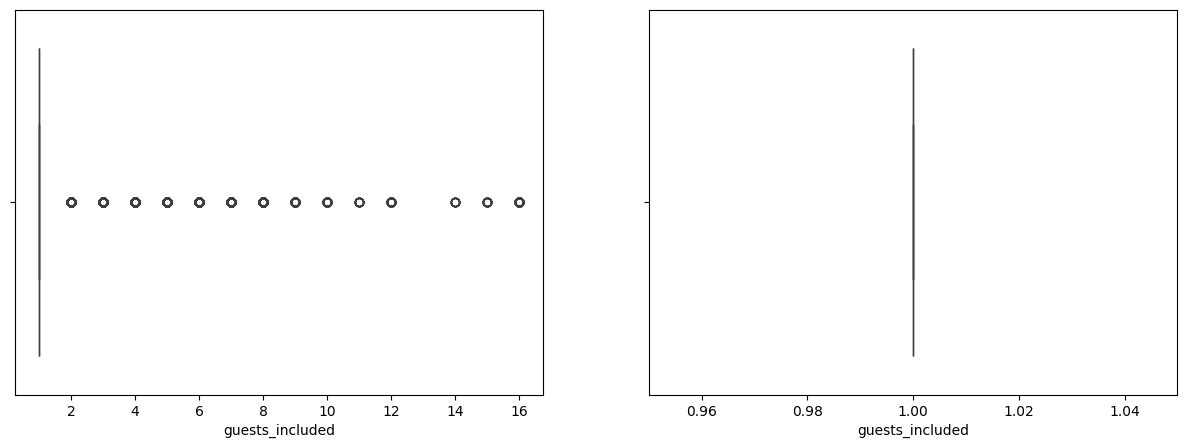

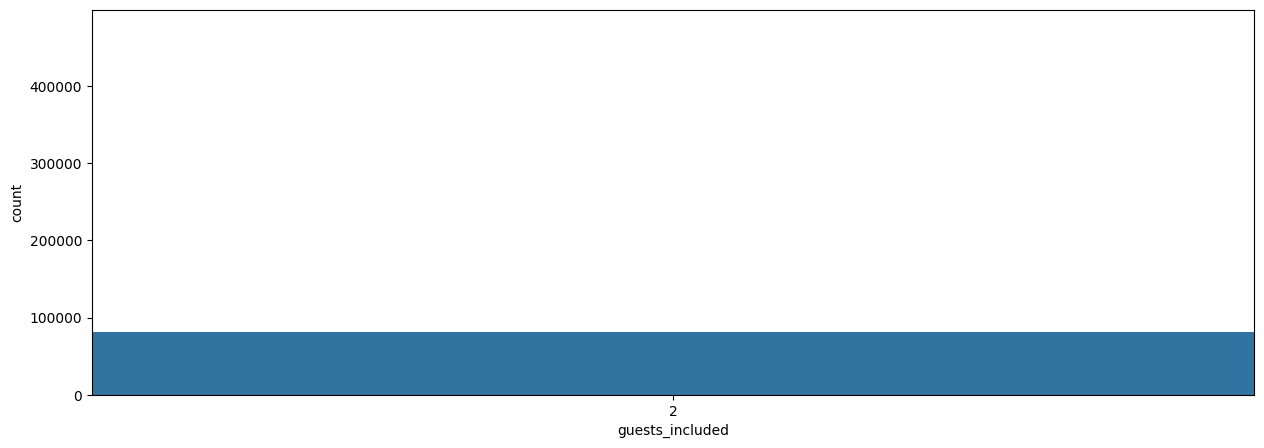

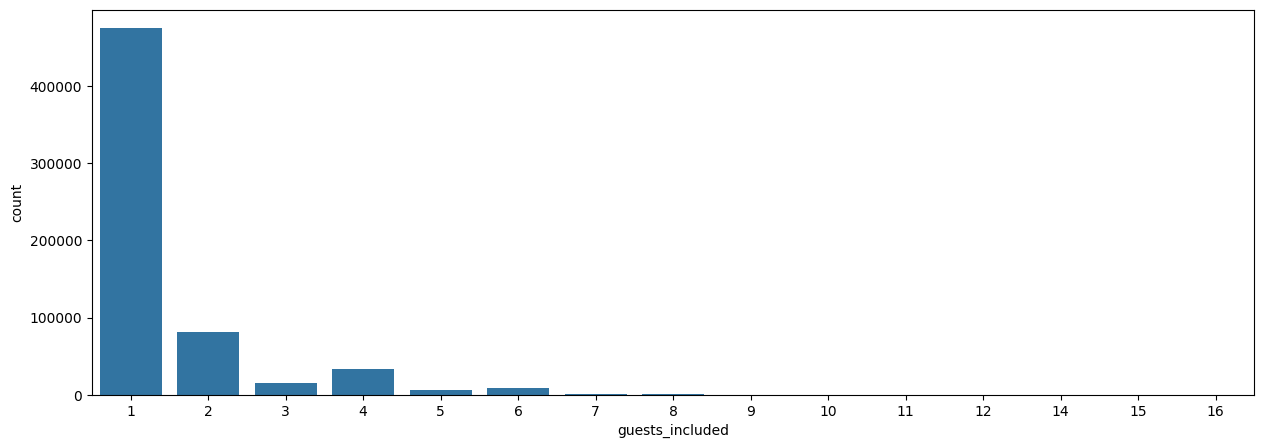

In [25]:
diagrama_caixa(base_airbnb['guests_included'])

grafico_barras(base_airbnb['guests_included'])

plt.figure(figsize=(15,5))

sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

### Iremos remover essa feature da análise,pois acreditamos que há um erro de preenchimento na hora da divulgação. Isso pode levar em consideração na hora de aplicarmos o modelo de preço

In [26]:
#Excluinda a coluna do DF
base_airbnb = base_airbnb.drop('guests_included',axis=1)

base_airbnb.shape

(622366, 22)

### minimum_nights & maximum_nights 

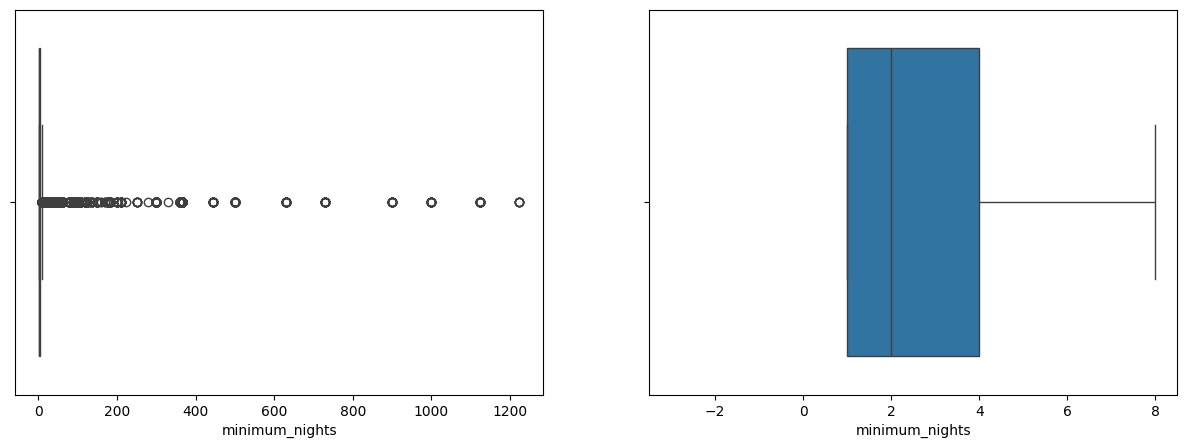

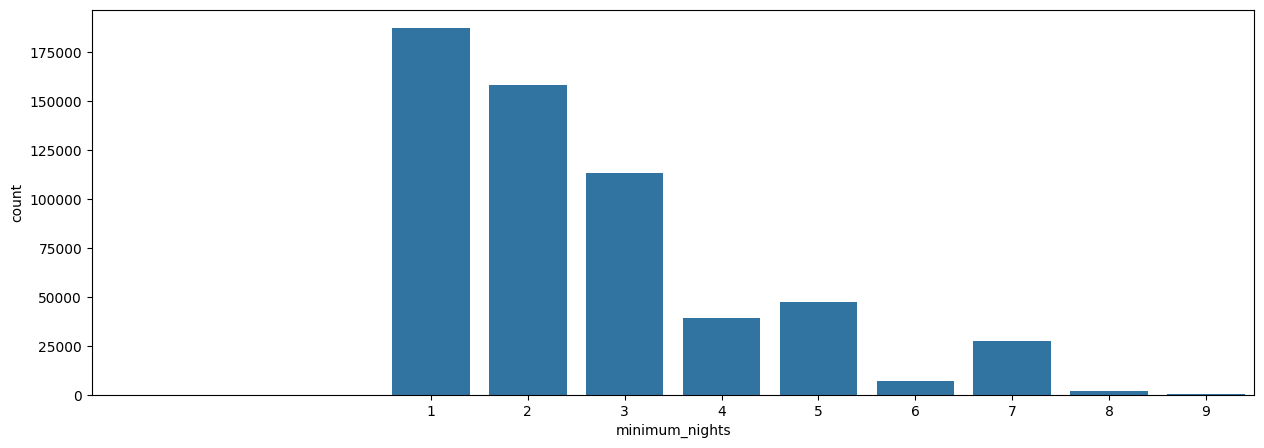

In [27]:
diagrama_caixa(base_airbnb['minimum_nights'])

grafico_barras(base_airbnb['minimum_nights'])

In [28]:
#REMOVENDO OUTLIERS PARA minimum_nights
base_airbnb, qnt_linhas = excluir_outliers(base_airbnb, 'minimum_nights')

print(f'Quantidade de linhas removidas: {qnt_linhas}')

Quantidade de linhas removidas: 40383


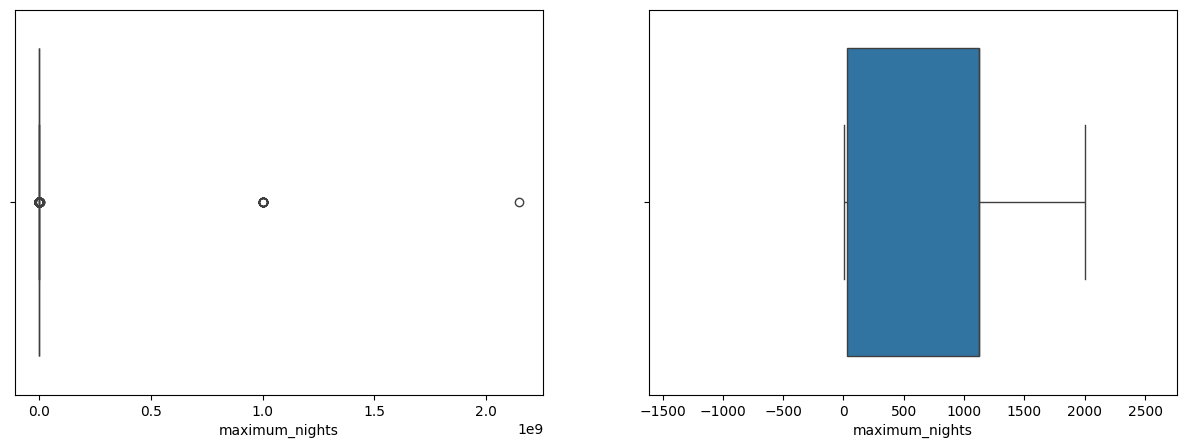

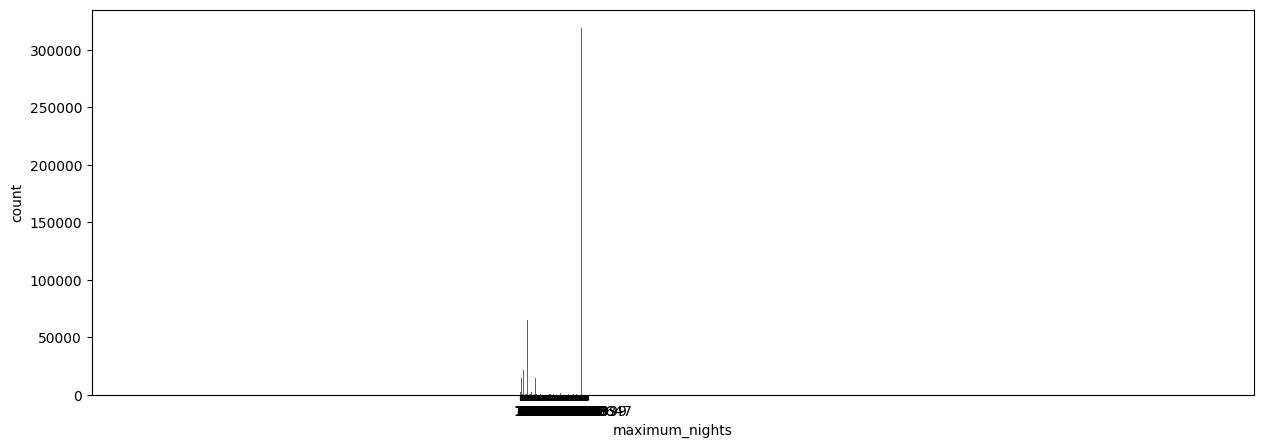

In [29]:
diagrama_caixa(base_airbnb['maximum_nights'])

grafico_barras(base_airbnb['maximum_nights'])

### Decidimos que maximum_nights apenas iria prejudicar a nossa análise, pois não haveria nenhum impacto no preço final e apenas atrapalharia a nossa análise

In [30]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)

base_airbnb.shape

(581983, 21)

### number_of_reviews

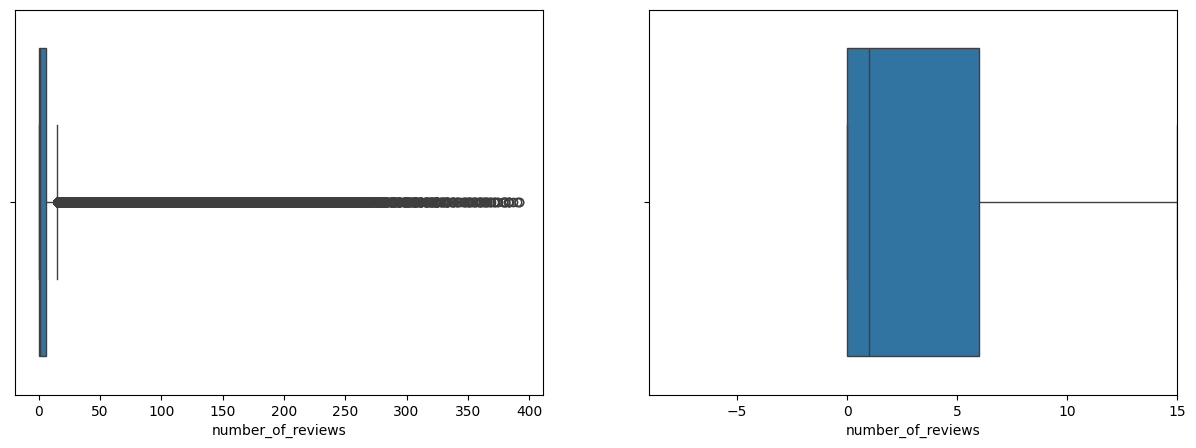

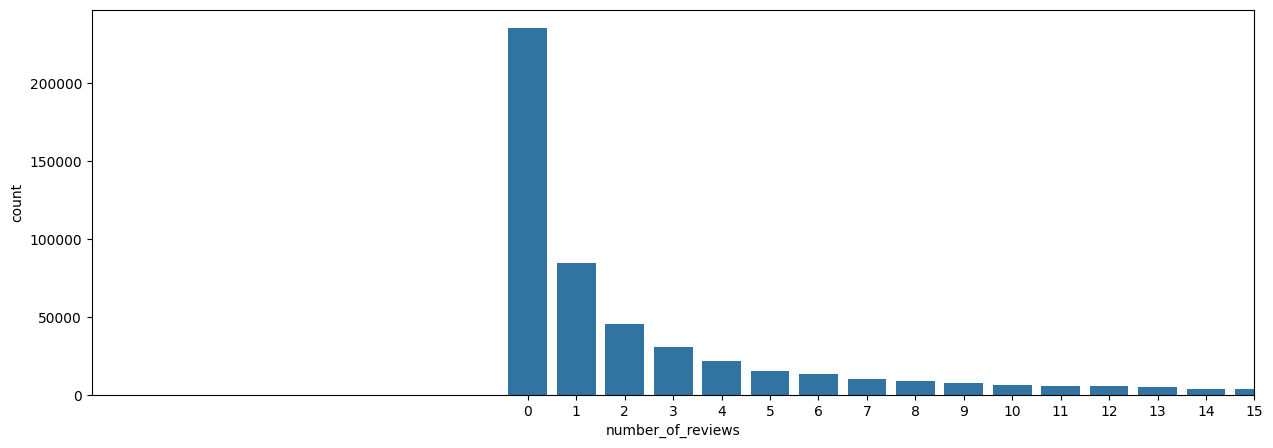

In [31]:
diagrama_caixa(base_airbnb['number_of_reviews'])

grafico_barras(base_airbnb['number_of_reviews'])

### Decidimos que iremos tirar o modelo de reviews, pois queremos que imóveis com zero review também poderemos levar em conta

In [32]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)

base_airbnb.shape

(581983, 20)

## Tratamento de colunas com valores de texto

#### Property_type

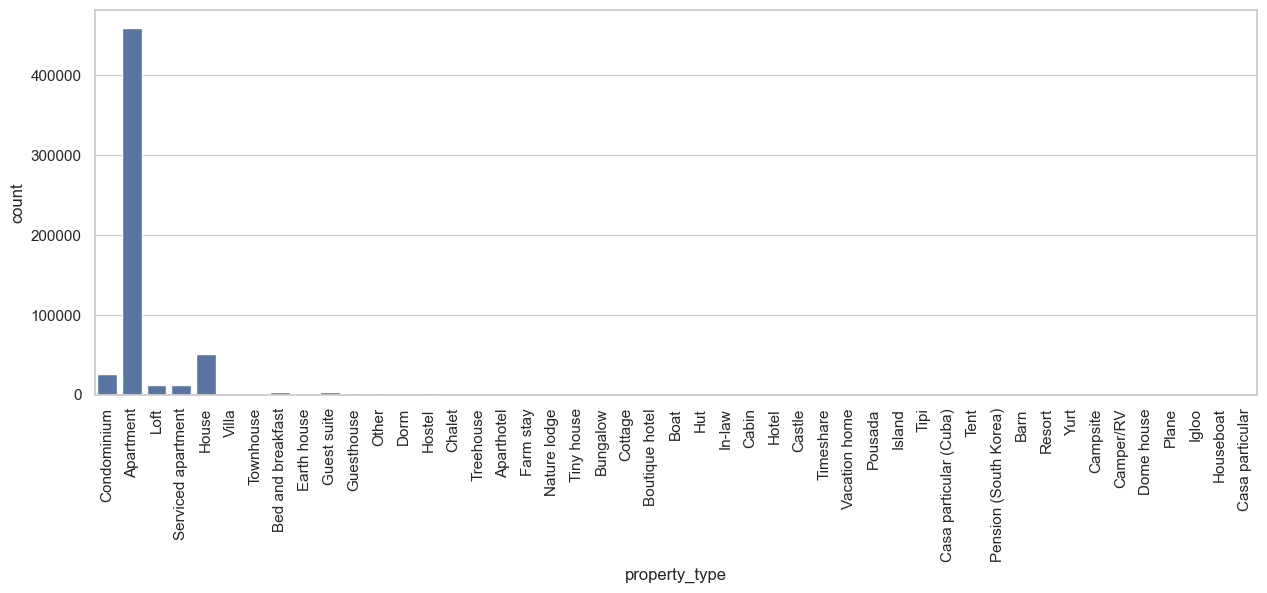

In [33]:
#Verificando a quantidade de valores distintos que há na coluna  e descrição
#print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15,5))
sns.set_theme(style="whitegrid")
grafico = sns.countplot(x=base_airbnb['property_type'])
grafico.tick_params(axis='x', rotation=90)                #rodar o texto do eixo X, para nao ficar um perto do outro



In [34]:
#Perorre todos as chaves e valores da coluna
tabela_tipos_de_casa = base_airbnb['property_type'].value_counts()  

coluna_agrupar =  []
#percorremos as linhas 
for tipo in tabela_tipos_de_casa.index:
    #vericamos o valor e fazemos a validação
    if tabela_tipos_de_casa[tipo] < 2000:
        coluna_agrupar.append(tipo)
print(coluna_agrupar)


for tipo in coluna_agrupar:
     base_airbnb.loc[base_airbnb['property_type'] == tipo, 'property_type'] = 'Outros'

print(base_airbnb['property_type'].value_counts())

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'Igloo', 'In-law', 'Vacation home', 'Timeshare', 'Pousada', 'Houseboat', 'Casa particular', 'Plane']
property_type
Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: count, dtype: int64


#### room_type

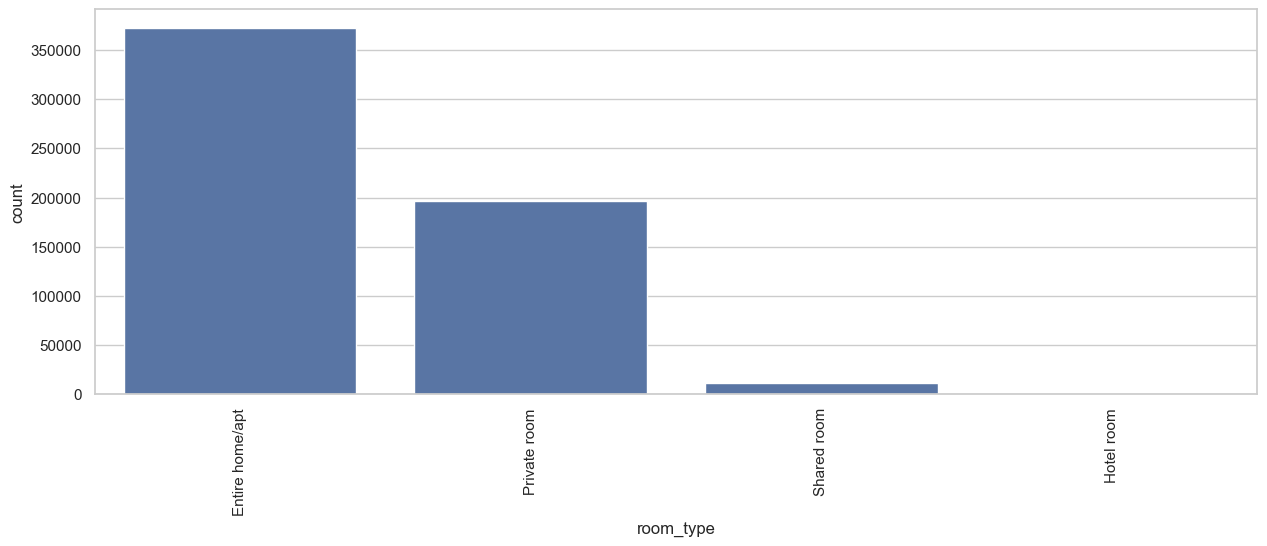

In [35]:
plt.figure(figsize=(15,5))
sns.set_theme(style="whitegrid")
grafico = sns.countplot(x=base_airbnb['room_type'])
grafico.tick_params(axis='x', rotation=90)                #rodar o texto do eixo X, para nao ficar um perto do outro

#### bed_type

bed_type
Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: count, dtype: int64


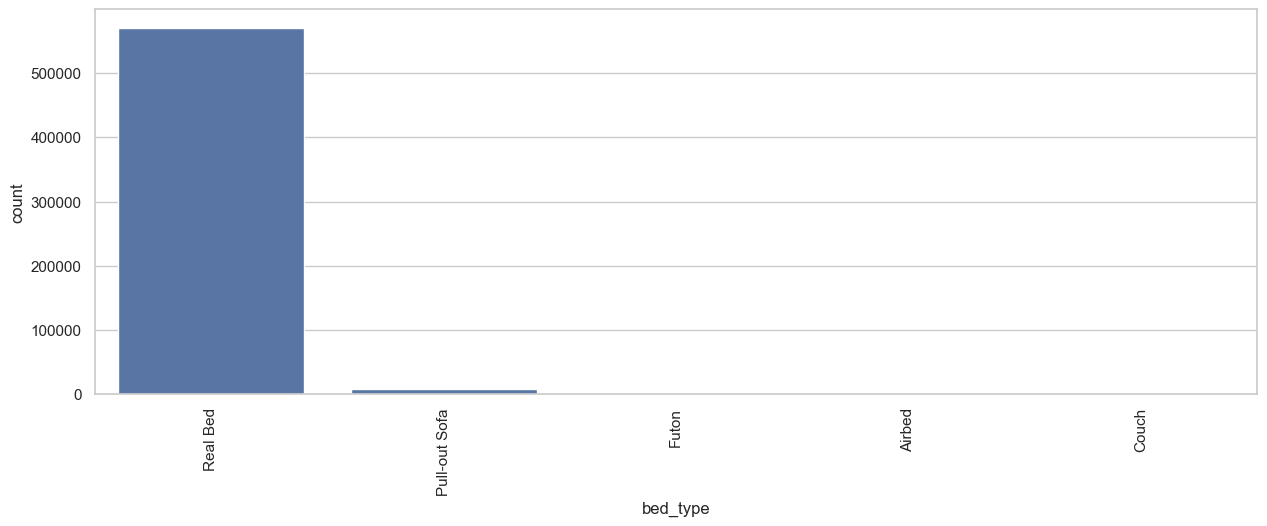

In [36]:
print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(15,5))
sns.set_theme(style="whitegrid")
grafico = sns.countplot(x=base_airbnb['bed_type'])
grafico.tick_params(axis='x', rotation=90)                #rodar o texto do eixo X, para nao ficar um perto do outro

bed_type
Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: count, dtype: int64
['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']
bed_type
Real Bed    570643
Outros       11340
Name: count, dtype: int64


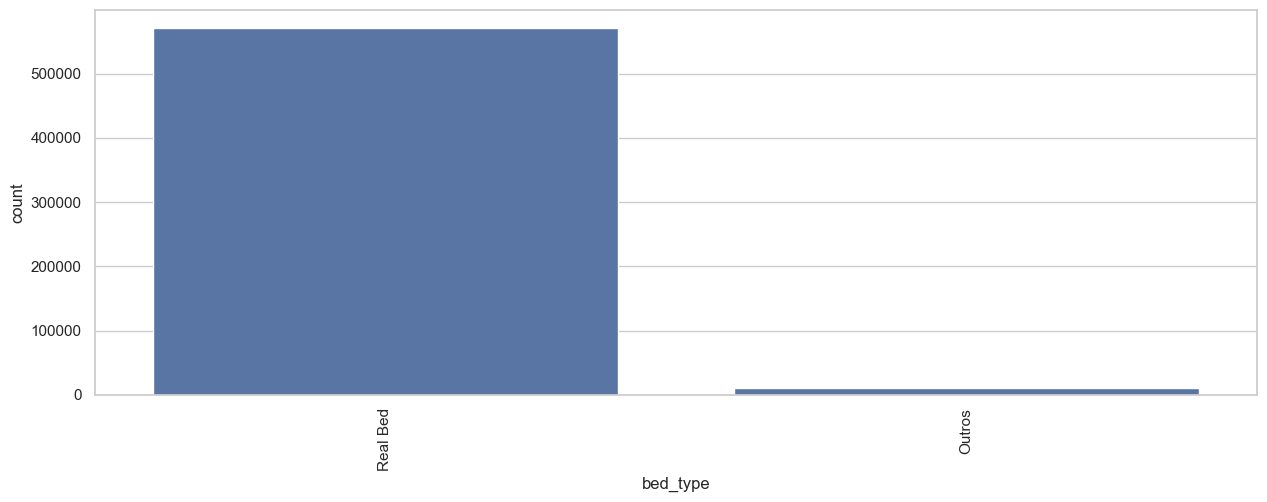

In [37]:
#Agrupar valores da coluna bed_type
#Perorre todos as chaves e valores da coluna

print(base_airbnb['bed_type'].value_counts())

tabelas_beds = base_airbnb['bed_type'].value_counts()  

coluna_agrupar =  []
#percorremos as linhas 
for tipo in tabelas_beds.index:
    #vericamos o valor e fazemos a validação
    if tabelas_beds[tipo] < 10000:
        coluna_agrupar.append(tipo)
print(coluna_agrupar)


for tipo in coluna_agrupar:
     base_airbnb.loc[base_airbnb['bed_type'] == tipo, 'bed_type'] = 'Outros'




plt.figure(figsize=(15,5))
sns.set_theme(style="whitegrid")
grafico = sns.countplot(x=base_airbnb['bed_type'])
grafico.tick_params(axis='x', rotation=90)                #rodar o texto do eixo X, para nao ficar um perto do outro

print(base_airbnb['bed_type'].value_counts())

#### cancellation_policy

cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: count, dtype: int64


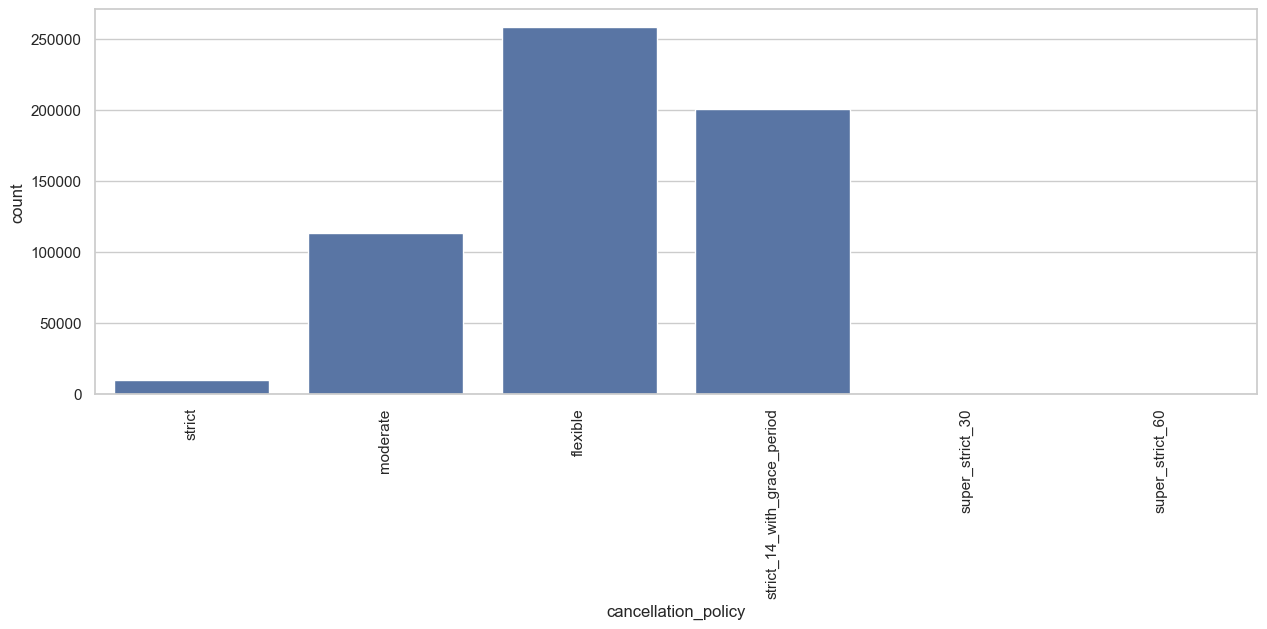

In [38]:
print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(15,5))
sns.set_theme(style="whitegrid")
grafico = sns.countplot(x=base_airbnb['cancellation_policy'])
grafico.tick_params(axis='x', rotation=90)                #rodar o texto do eixo X, para nao ficar um perto do outro

['strict', 'super_strict_60', 'super_strict_30']
cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: count, dtype: int64
cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: count, dtype: int64


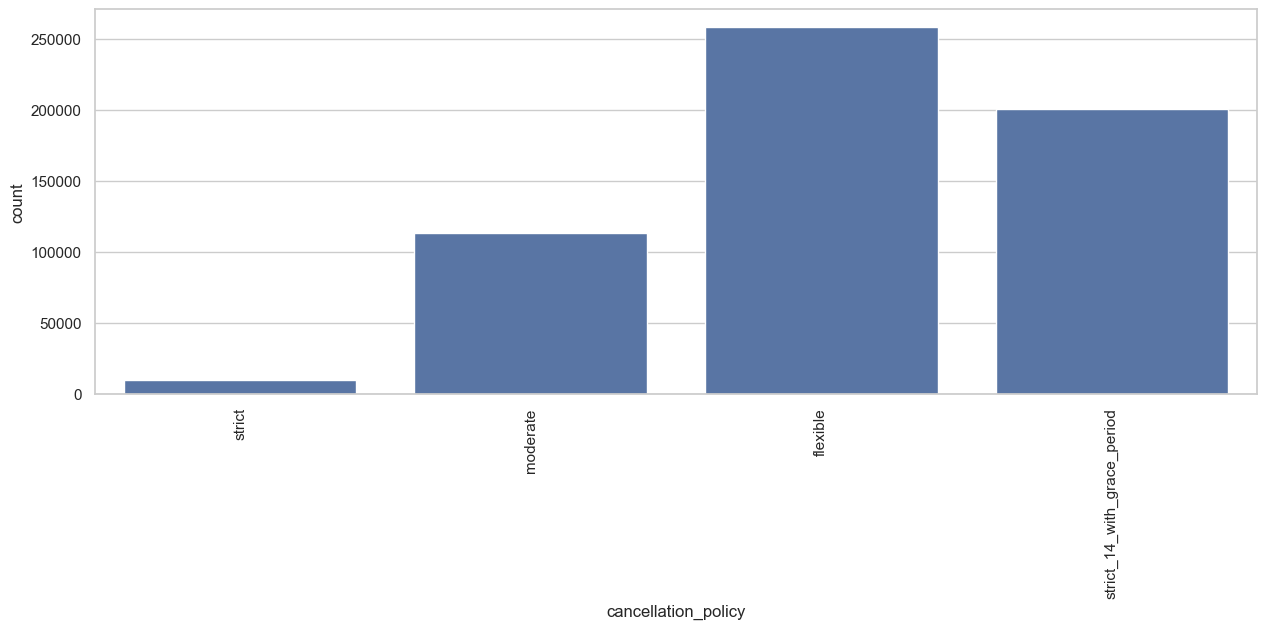

In [39]:
#Agrupar valores da coluna
#Perorre todos as chaves e valores da coluna
tabelas_cancellation = base_airbnb['cancellation_policy'].value_counts()  

coluna_agrupar =  []
#percorremos as linhas 
for tipo in tabelas_cancellation.index:
    #vericamos o valor e fazemos a validação
    if tabelas_cancellation[tipo] < 10000:
        coluna_agrupar.append(tipo)
print(coluna_agrupar)


for tipo in coluna_agrupar:
     base_airbnb.loc[base_airbnb['cancellation_policy'] == tipo, 'cancellation_policy'] = 'strict'

print(base_airbnb['cancellation_policy'].value_counts())



print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(15,5))
sns.set_theme(style="whitegrid")
grafico = sns.countplot(x=base_airbnb['cancellation_policy'])
grafico.tick_params(axis='x', rotation=90)                #rodar o texto do eixo X, para nao ficar um perto do outro

#### amenities

- Iremos criar uma coluna separada de amenities, e iremos contar os valores e adicionar nessa nossa nova coluna. Pois temos uma diversidade muita grande de amenities, assim para o nosos modelo futuro, quanto mais amenities tiver mais poderá impactar o valor

In [40]:
print(base_airbnb['amenities'].iloc[1].split(','))
print(len(base_airbnb['amenities'].iloc[1].split(',')))

base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

base_airbnb = base_airbnb.drop('amenities', axis=1)

base_airbnb.shape
display(base_airbnb)

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', 'Doorman', 'Elevator', '"Buzzer/wireless intercom"', '"Family/kid friendly"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"}']
14


host_is_superhost  host_listings_count   latitude  longitude  \
1                      t                  2.0 -22.965919 -43.178962   
3                      f                  3.0 -22.977117 -43.190454   
4                      t                  1.0 -22.983024 -43.214270   
5                      t                  1.0 -22.988165 -43.193588   
6                      t                  1.0 -22.981269 -43.190457   
...                  ...                  ...        ...        ...   
902204                 f                  1.0 -22.986030 -43.191660   
902205                 f                  0.0 -23.003180 -43.342840   
902206                 f                  0.0 -22.966640 -43.393450   
902208                 f                  0.0 -23.003400 -43.341820   
902209                 f                  5.0 -23.010560 -43.363350   

       property_type        room_type  accommodates  bathrooms  bedrooms  \
1        Condominium  Entire home/apt             5        1.0       2.0   
3          Apartment  Entire home/apt             3        1.0       1.0   
4          Apartment  Entire home/apt             3        1.0       1.0   
5          Apartment  Entire home/apt             3        1.5       1.0   
6               Loft  Entire home/apt             2        1.0       1.0   
...              ...              ...           ...        ...       ...   
902204     Apartment  Entire home/apt             4        2.0       2.0   
902205     Apartment  Entire home/apt             4        1.0       0.0   
902206     Apartment  Entire home/apt             4        2.0       2.0   
902208     Apartment  Entire home/apt             4        1.0       1.0   
902209     Apartment     Private room             2        0.0       1.0   

        beds  bed_type  price  extra_people  minimum_nights instant_bookable  \
1        2.0  Real Bed  270.0          51.0               4                t   
3        2.0  Real Bed  161.0          45.0               4                f   
4        2.0  Real Bed  222.0          68.0               2                t   
5        2.0  Real Bed  308.0          86.0               2                f   
6        2.0  Real Bed  219.0          80.0               3                t   
...      ...       ...    ...           ...             ...              ...   
902204   3.0  Real Bed  250.0           0.0               1                f   
902205   2.0  Real Bed  121.0          50.0               1                f   
902206   3.0  Real Bed  799.0           0.0               2                f   
902208   1.0  Real Bed  250.0           0.0               1                f   
902209   1.0  Real Bed   92.0          80.0               1                f   

       is_business_travel_ready          cancellation_policy   ano  mes  \
1                             f                       strict  2018    4   
3                             f                       strict  2018    4   
4                             f                       strict  2018    4   
5                             f                       strict  2018    4   
6                             f                       strict  2018    4   
...                         ...                          ...   ...  ...   
902204                        f                     flexible  2019    9   
902205                        f                     flexible  2019    9   
902206                        f                     flexible  2019    9   
902208                        f  strict_14_with_grace_period  2019    9   
902209                        f  strict_14_with_grace_period  2019    9   

        n_amenities  
1                25  
3                14  
4                16  
5                30  
6                30  
...             ...  
902204           15  
902205           18  
902206           12  
902208           25  
902209           17  

[581983 rows x 20 columns]

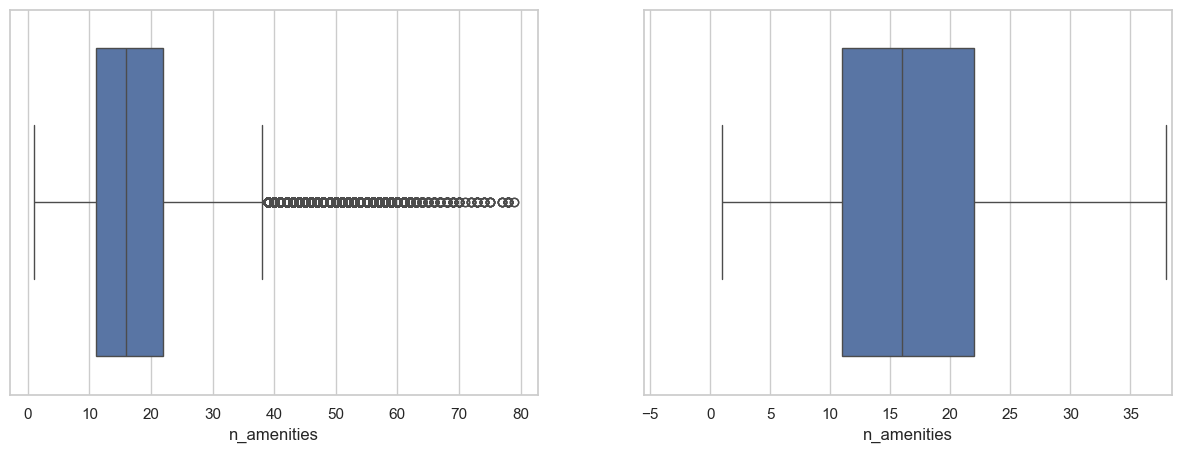

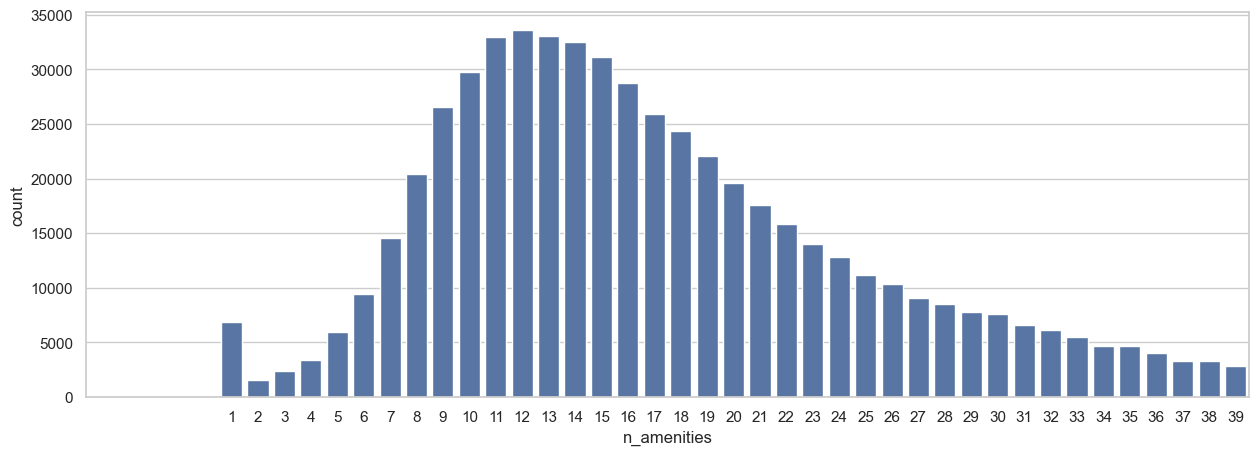

In [41]:
#outliers de amenitis

diagrama_caixa(base_airbnb['n_amenities'])
grafico_barras(base_airbnb['n_amenities'])

In [42]:
#EXCLUINDO OUTLIERS

base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')

print(f"{linhas_removidas} foram os numeros de linhas removidas")

24343 foram os numeros de linhas removidas


### Visualização de mapa das propriedades

In [43]:
#Pegamos 50000 valores aleatórios para serem gerados no mapa
amostra = base_airbnb.sample(n=70000)
#o centro do mapa, vai ser a média da longitude e latitude
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}

mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price', radius=2.5, center=centro_mapa, zoom=10,mapbox_style='open-street-map')

mapa.show()


### Encoding

- Iremos ajustar as features para o preparo do modelo

- Features de valores lógicos, será 1 e 0

- E valores de colunas que são textos, vamos ultilizar o método de encondig que são dummies

In [44]:
#Colunas TRUE or False
colunas_tf =  ['host_is_superhost','instant_bookable','is_business_travel_ready']
#criar uma copia do DF
base_airbnb_cod = base_airbnb.copy()

for coluna in colunas_tf:
  base_airbnb_cod.loc[base_airbnb_cod[coluna] == 't', coluna] = 1  #se a coluna for t, mudar para 1
  base_airbnb_cod.loc[base_airbnb_cod[coluna] == 'f', coluna] = 0  #se a coluna for f, mudar para 0

print(base_airbnb_cod.iloc[0])

host_is_superhost                         1
host_listings_count                     2.0
latitude                         -22.965919
longitude                        -43.178962
property_type                   Condominium
room_type                   Entire home/apt
accommodates                              5
bathrooms                               1.0
bedrooms                                2.0
beds                                    2.0
bed_type                           Real Bed
price                                 270.0
extra_people                           51.0
minimum_nights                            4
instant_bookable                          1
is_business_travel_ready                  0
cancellation_policy                  strict
ano                                    2018
mes                                       4
n_amenities                              25
Name: 1, dtype: object


In [45]:
colunas_categoria = ['property_type','room_type','bed_type','cancellation_policy']

base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categoria)

display(base_airbnb_cod.head())

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
1                 1                  2.0 -22.965919 -43.178962             5   
3                 0                  3.0 -22.977117 -43.190454             3   
4                 1                  1.0 -22.983024 -43.214270             3   
5                 1                  1.0 -22.988165 -43.193588             3   
6                 1                  1.0 -22.981269 -43.190457             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  \
1        1.0       2.0   2.0  270.0          51.0  ...   
3        1.0       1.0   2.0  161.0          45.0  ...   
4        1.0       1.0   2.0  222.0          68.0  ...   
5        1.5       1.0   2.0  308.0          86.0  ...   
6        1.0       1.0   2.0  219.0          80.0  ...   

   room_type_Entire home/apt room_type_Hotel room room_type_Private room  \
1                       True                False                  False   
3                       True                False                  False   
4                       True                False                  False   
5                       True                False                  False   
6                       True                False                  False   

   room_type_Shared room  bed_type_Outros  bed_type_Real Bed  \
1                  False            False               True   
3                  False            False               True   
4                  False            False               True   
5                  False            False               True   
6                  False            False               True   

   cancellation_policy_flexible  cancellation_policy_moderate  \
1                         False                         False   
3                         False                         False   
4                         False                         False   
5                         False                         False   
6                         False                         False   

   cancellation_policy_strict  cancellation_policy_strict_14_with_grace_period  
1                        True                                            False  
3                        True                                            False  
4                        True                                            False  
5                        True                                            False  
6                        True                                            False  

[5 rows x 36 columns]

### Modelo de Previsão

- Métricas de Avaliação

In [46]:
#Definindo a função para avaliar modelo
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo} \nR²: {r2}\nRSME: {RSME}'

- Escolha dos modelos a serem testados
1.0 Random Forrest
2.0 Regressão Linear
3.0 Extra Tree

In [47]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()
modelos = {'RandomForest': modelo_rf,
           'LinearRegression': modelo_lr,
           'ExtraTrees': modelo_et,
           }

y = base_airbnb_cod['price']
x = base_airbnb_cod.drop('price', axis=1)

- Separar os dados de treino e de teste

In [48]:
x_train,x_teste,y_train,y_test = train_test_split(x, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(x_train, y_train)
    #testar
    previsao = modelo.predict(x_teste)
    print(avaliar_modelo(nome_modelo,y_test,previsao))

    # Libera memória após o treino do modelo
    del modelo
    gc.collect()

Modelo RandomForest 
R²: 0.9724526884690825
RSME: 44.01227046826368
Modelo LinearRegression 
R²: 0.32701687901408527
RSME: 217.53855974042662
Modelo ExtraTrees 
R²: 0.9748723278167964
RSME: 42.03492643849464


### Análise do Melhor Modelo

### Ajustes e Melhorias no Melhor Modelo